<a href="https://github.com/tianjianjiang/nlp_data_aug/blob/%232-double_redaction/DataAugmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
torch.cuda.set_device(1)

In [2]:
from fastai import *
from fastai.text import *

In [10]:
path = Path('data/trec')
path.ls()

[PosixPath('data/trec/train_5500.label'), PosixPath('data/trec/TREC_10.label')]

In [7]:
from torchnlp.datasets import trec_dataset

In [170]:
train = trec_dataset(train=True)
test = trec_dataset(test=True)

In [171]:
train[:2],test[:2]

([{'label': 'DESC',
   'text': 'How did serfdom develop in and then leave Russia ?'},
  {'label': 'ENTY',
   'text': 'What films featured the character Popeye Doyle ?'}],
 [{'label': 'NUM', 'text': 'How far is it from Denver to Aspen ?'},
  {'label': 'LOC', 'text': 'What county is Modesto , California in ?'}])

In [172]:
len(train)

5452

In [176]:
text = [t["text"] for t in train] + [t["text"] for t in test]
label = [t["label"] for t in train] + [t["text"] for t in test]
df = pd.DataFrame(np.stack([text,label],1),columns=["text","label"])
df.head()

,text,label
0,How did serfdom develop in and then leave Russ...,DESC
1,What films featured the character Popeye Doyle ?,ENTY
2,How can I find a list of celebrities ' real na...,DESC
3,What fowl grabs the spotlight after the Chines...,ENTY
4,What is the full form of .com ?,ABBR


In [18]:
data_lm = (TextList.from_df(df,path,cols="text")
                   .split_by_idx(list(range(5452,len(df))))
                   .label_for_lm()
                   .databunch())
data_lm.show_batch()

idx,text
0,contemptible scoundrel stole the cork from my lunch ? xxbos xxmaj what team did baseball 's xxmaj st. xxmaj louis xxmaj xxunk become ? xxbos xxmaj what is the oldest profession ? xxbos xxmaj what are xxunk xxunk ? xxbos xxmaj name the xxunk - faced bounty hunter of xxmaj the xxmaj old xxmaj west . xxbos xxmaj when was xxmaj xxunk xxmaj xxunk born ? xxbos xxmaj why do
1,xxunk ? xxbos xxmaj what country 's national xxunk xxunk system is called xxmaj xxunk ? xxbos xxmaj who invented xxmaj make - up ? xxbos xxmaj what is the origin of the word ` ` xxunk '' ? xxbos xxmaj what did xxmaj xxunk do to xxmaj xxunk 's hair ? xxbos xxmaj what kind of animals were in the xxmaj xxunk era ? xxbos xxmaj which of the
2,plan ? xxbos xxmaj what causes xxunk ? xxbos xxmaj what are the three winter months in the southern xxunk ? xxbos xxmaj what does xxunk mean ? xxbos xxmaj what country contains xxmaj africa 's northernmost point ? xxbos xxmaj what xxunk xxunk to xxunk the ` ` xxunk xxunk '' ? xxbos xxmaj where is the xxmaj xxunk desert ? xxbos xxmaj which xxmaj ventura xxmaj county police
3,come in ? xxbos xxmaj who was the lead actress in the movie ` xxmaj xxunk in xxmaj seattle ' ? xxbos xxmaj who was the 16th xxmaj president of the xxmaj united xxmaj states ? xxbos xxmaj who are the two sons of xxmaj xxunk and xxmaj xxunk xxmaj xxunk ? xxbos xxmaj what is xxunk ? xxbos xxmaj when is xxmaj boxing xxmaj day ? xxbos xxmaj what
4,from the xxmaj xxunk ? xxbos xxmaj what does it mean ` ` xxmaj xxunk xxmaj xxunk '' ? xxbos xxmaj what xxunk xxunk were dubbed ` ` xxmaj mississippi xxunk '' and ` ` xxmaj xxunk xxunk '' ? xxbos xxmaj who was the first coach of the xxmaj cleveland xxmaj xxunk ? xxbos xxmaj how successful is xxunk ? xxbos xxmaj what xxmaj jewish xxunk saw the start


In [22]:
learn = language_model_learner(data_lm,AWD_LSTM,drop_mult=0.3)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


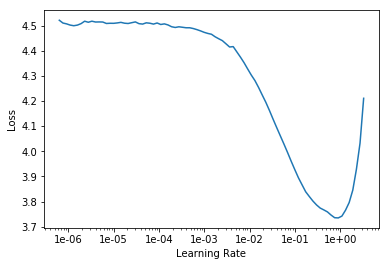

In [23]:
learn.lr_find()
learn.recorder.plot()

In [24]:
learn.fit_one_cycle(2,2e-2,moms=(0.7,0.8))

epoch,train_loss,valid_loss,accuracy,time
0,3.575221,2.098988,0.578571,00:01
1,2.945932,1.988968,0.594531,00:01


In [25]:
learn.unfreeze()
learn.fit_one_cycle(5,3e-3,moms=(0.7,0.8))

epoch,train_loss,valid_loss,accuracy,time
0,2.340613,1.951747,0.604911,00:01
1,2.192014,1.828391,0.610826,00:01
2,1.980070,1.813960,0.619196,00:01
3,1.759211,1.821718,0.618638,00:01
4,1.584562,1.851841,0.613951,00:01


In [26]:
learn.save("trec6-model")
learn.save_encoder("trec6-encoder")

In [27]:
import spacy
import random
import nltk 
from nltk.corpus import wordnet 
import en_core_web_lg
import re

In [99]:
subject_pronouns = ["i", "you", "he", "she", "it", "they"]
object_pronouns = ["me", "you", "him", "her", "it"]
possessive_pronouns = ["my", "mine", "your", "yours", "his", "her", "hers", "its"]
interrogative_pronouns = ["who", "whom", "whose", "what", "which"]
indefinite_pronouns = ["another", "each", "everything", "nobody", "either", "someone"]
relative_pronouns = ["who", "whom", "whose", "that", "which"]
reflexive_pronouns = ["myself", "yourself", "himself", "herself", "itself"]
demonstrative_pronouns = ["this", "that"]
pronouns = [subject_pronouns,object_pronouns,possessive_pronouns,interrogative_pronouns,
           indefinite_pronouns,relative_pronouns,demonstrative_pronouns]

In [143]:
def synalter_noun_verb_adjective_pronoun(cand_word,POS):
    thresh = -1
    scores = []
    if POS == "prn": 
        for p_list in pronouns:
            synonyms = [p for p in p_list if p != cand_word and cand_word in p_list]
    else: synonyms = wordnet.synsets(cand_word)
    for w2 in synonyms:
        try:
            w1 = wordnet.synset(cand_word+'.'+POS+'.01') 
        #w2 = wordnet.synset(word+'.'+POS+'.01') # n denotes noun 
            if (w1.wup_similarity(w2)>thresh):
                scores.append(w1.wup_similarity(w2))
            return synonyms[np.argmax(scores)].name().split('.')[0].replace('_',' ')
        except:
            if not scores:
                for synset in synonyms:
                    word=synset.name().split('.')[0].replace('_',' ')
                    #print(word)
                    token = nlp(word)
                    token_main = nlp(cand_word)
                    if token.vector_norm and token_main.vector_norm and float(token.similarity(token_main)) > thresh:
                        scores.append(float(token.similarity(token_main)))
            if not scores: return None
            return synonyms[np.argmax(scores)].name().split('.')[0].replace('_',' ')

In [31]:
nlp = spacy.load('en_core_web_lg')

In [32]:
doc = nlp('he bright car running')
[tok.pos_ for tok in doc]

['PRON', 'ADJ', 'NOUN', 'VERB']

In [129]:
def change_words(word_str,pos,output_text):
    change_word=synalter_noun_verb_adjective_pronoun(word_str,pos)
    if change_word:
        search_word = re.search(r'\b'+word_str+r'\b', output_text)
        if not search_word: search_word = re.search(word_str, output_text)
        Loc = search_word.start()
        output_text = output_text[:int(Loc)] + change_word + output_text[int(Loc) + len(word_str):] 
        
    return output_text

In [191]:
aug_texts,aug_labels=[],[]

In [192]:
class text_augmenter(object):
    #def __init__(self):
    
    def __call__(self, text,i): 
        #print(f'augmenting file {fn}')
        output_text = deepcopy(text)
        #print("Sentence: "+text)
        counts = Counter(output_text.split(" "))
        noun = []
        verb = []
        doc = nlp(' '.join(w for w in [key for key,value in counts.items() if value ==1]))
        noun = [tok.text for tok in doc if tok.pos_ == 'NOUN']
        verb = [tok.text for tok in doc if tok.pos_ == 'VERB']
        adj = [tok.text for tok in doc if tok.pos_ == 'ADJ']
        pro = [tok.text for tok in doc if tok.pos_ == 'PRON']
        cand_words = noun+verb+adj+pro
        len_all = len(verb+noun+adj+pro)
        random.seed(4)
        temp = random.sample(range(len_all), random.randint(0,int(len_all*0.9)))
        #print([cand_words[i] for i in temp])
        for i in temp:
            word_str = cand_words[i]
            if i<len(verb):output_text = change_words(word_str,'v',output_text)
            elif i<len(noun): output_text = change_words(word_str,'n',output_text)
            elif i<len(adj):output_text=change_words(word_str,'a',output_text)
            else:output_text=change_words(word_str,'prn',output_text)
        #new_fn = fn.replace('.txt','_aug.txt')
        #with open(new_fn,'w') as f:
        #    f.write(output_text)
        if output_text != text: 
            aug_texts.append(output_text)
            aug_labels.append(label[i])
        #print(f'saving augmented file to {new_fn}')

In [195]:
for i in range(5452):
    text_augmenter()(text[i],i)
#parallel(text_augmenter(),text[:5452])

In [196]:
len(aug_texts),len(aug_labels)

(758, 758)

In [202]:
text = [t["text"] for t in train] + aug_texts + [t["text"] for t in test]
label = [t["label"] for t in train] + aug_labels + [t["label"] for t in test]
df = pd.DataFrame(np.stack([text,label],1),columns=["text","label"])
df.head()

,text,label
0,How did serfdom develop in and then leave Russ...,DESC
1,What films featured the character Popeye Doyle ?,ENTY
2,How can I find a list of celebrities ' real na...,DESC
3,What fowl grabs the spotlight after the Chines...,ENTY
4,What is the full form of .com ?,ABBR


In [203]:
len(df)

6710

In [204]:
data_clas = (TextList.from_df(df,path,cols=["text"], vocab=data_lm.vocab)
             #grab all the text files in path
             .split_by_idxs(train_idx=list(range(0,5452+758)),valid_idx=list(range(5452+758,len(df))))             
             #split by train and valid folder (that only keeps 'train' and 'test' so no need to filter)
             .label_from_df(cols=["label"])
             #label them all with their folders
             .databunch())

In [206]:
learn = text_classifier_learner(data_clas,AWD_LSTM,drop_mult=0.5)

In [207]:
learn.load_encoder("trec6-encoder")

In [208]:
learn.fit_one_cycle(1, 2e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,1.055830,0.525788,0.852000,00:05


In [209]:
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(1e-2/(2.6**4),1e-2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.858284,0.439564,0.846000,00:05


In [210]:
learn.freeze_to(-3)
learn.fit_one_cycle(1, slice(5e-3/(2.6**4),5e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.695052,0.283462,0.894000,00:05


In [211]:
learn.unfreeze()
learn.fit_one_cycle(2, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.567326,0.268075,0.912000,00:06
1,0.535638,0.251306,0.916000,00:06
